In [1]:
import os 
import random
import matplotlib.pyplot as plt
import json
import numpy as np
import cv2
import typing as t
from tqdm import tqdm
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout, Attention,concatenate, Layer, TextVectorization, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model


In [2]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [3]:
base_dir = 'C:\\Kingsley\\multimodia-hatespeech\\'
print(os.listdir(base_dir))

['4FE40520', 'bert only.ipynb', 'example1.xlsx', 'Final_dataset4.csv', 'fyp(backup).ipynb', 'fyp.ipynb', 'glove.6B.300d.txt', 'hatespeech_keywords.txt', 'image_latest(balanced)', 'image_latest(balanced)(testing)(resized)', 'image_trying_new', 'image_trying_new_resized', 'image_trying_text_new', 'img_dataset', 'img_resized', 'img_txt', 'img_txt(latest)', 'latest.xlsx', 'latestbeforeStemandLemma.xlsx', 'latestV3(balanced).xlsx', 'latestV3(removedOCRText).xlsx', 'latestV3.xlsx', 'merged(Text)(CleanedLatest)(latest).xlsx', 'merged(Text)(CleanedLatest).xlsx', 'merged(Text).xlsx', 'MMHS150K_GT.json', 'MMHS150K_readme.txt', 'model', 'modelDevelopment.ipynb', 'modelDevelopment2.ipynb', 'modelDevelopment3.ipynb', 'model_Development.py', 'multimodal-meme-classifcation(5).ipynb', 'multimodal-meme-classification (1).ipynb', 'multimodal-meme-classification(3).ipynb', 'multimodal-meme-classification(4).ipynb', 'multimodal-meme-classification.ipynb', 'multimodal_attention_model', 'multimodal_attentio

In [4]:
splits_path = os.path.join(base_dir, 'splits\\')
print(os.listdir(splits_path))

['test_ids.txt', 'train_ids.txt', 'val_ids.txt']


In [5]:
##Function to read file IDs of train, val, test splits
def read_ids(path):
    with open(path) as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
        
        return lines
    

In [6]:
train_id_path = os.path.join(splits_path, 'train_ids.txt')
val_id_path = os.path.join(splits_path, 'val_ids.txt')
test_id_path = os.path.join(splits_path, 'test_ids.txt')

train_ids = read_ids(train_id_path)
val_ids = read_ids(val_id_path)
test_ids = read_ids(test_id_path)

In [7]:
print(f"Training data size: {len(train_ids)}")
print(f"Validation data size: {len(val_ids)}")
print(f"Testing data size: {len(test_ids)}")

Training data size: 134823
Validation data size: 5000
Testing data size: 10000


In [8]:
img_dir = os.path.join(base_dir, 'img_resized')
text_dir = os.path.join(base_dir, 'img_txt')

In [9]:
##Check if there are any missing entries from either images or text
print(f"Number of images: {len(os.listdir(img_dir))}")
print(f"Number of text files: {len(os.listdir(text_dir))}")

Number of images: 150000
Number of text files: 59252


In [10]:
##Checking the images which dont have corresponding text files
remove_extension = lambda x : x.split('.')[0]

missing_text = set(map(remove_extension, os.listdir(img_dir))) - set(map(remove_extension, os.listdir(text_dir))) 

In [11]:
missing_text = list(missing_text)

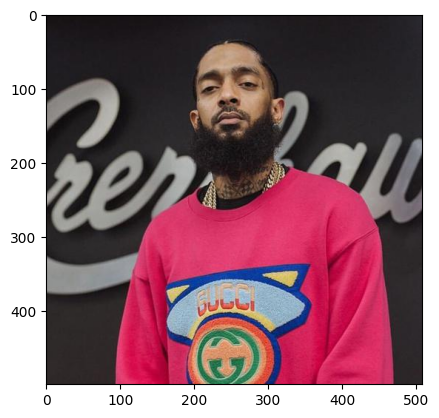

In [12]:
##Plotting an image randomly from those which dont have corresponding image texts
## Cell can be run multiple times to verify that these images don't have text
random_image = plt.imread(os.path.join(img_dir, random.choice(missing_text))+'.jpg')
plt.imshow(random_image)

## POSSIBLY NSFW CELL BELOW

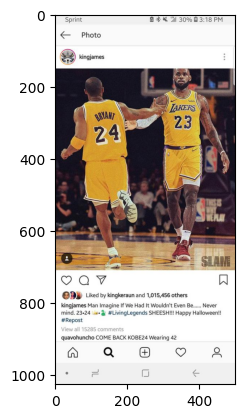

In [13]:
with_text_imgs = set(map(remove_extension, os.listdir(img_dir))).intersection(set(map(remove_extension, os.listdir(text_dir))))
with_text_imgs = list(with_text_imgs)

img_name = random.choice(with_text_imgs)
img_with_text_path = plt.imread(os.path.join(img_dir, img_name + '.jpg'))
plt.imshow(img_with_text_path)

In [14]:
print(os.path.join(text_dir, img_name + '.json'))

C:\Kingsley\multimodia-hatespeech\img_txt\1057728808521003008.json


In [15]:
with open(os.path.join(text_dir, img_name + '.json')) as f:
    d = json.load(f)
    print(d)

{'img_text': "30%3:18 PM Sprint Photo kingjames wish AKERS 23 24 SLAME Liked by kingkeraun and 1,015,456 others kingjames Man Imagine If We Had It Wouldn't Even Be. Never mind. 23.24-a. #LivingLegends SHEESH!! Happy Halloween! # Repost View all 15285 comments quavohuncho COME BACK KOBE24 Wearing 42 "}


In [16]:
def preprocess_text(text: str, encoding='utf-8') -> str:
    try:
        # Convert to lowercase
        text = text.lower()

        # Non-word character Removal
        text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)
        
        # Digits Removal
        text = re.sub(r'\d', '', text)

        # Remove punctuation
        PUNCT_TO_REMOVE = string.punctuation
        text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
        
        # Remove stopwords
        STOPWORDS = set(stopwords.words('english'))
        text = " ".join([word for word in text.split() if word not in STOPWORDS])
        
        # Stem words
        stemmer = SnowballStemmer(language='english')
        text = " ".join([stemmer.stem(word) for word in text.split()])

        # Remove URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        text = url_pattern.sub(r'', text)

        # Remove HTML tags
        html_pattern = re.compile('<.*?>')
        text = html_pattern.sub(r'', text)

        return text
    except UnicodeDecodeError as e:
        print(f"UnicodeDecodeError in preprocess_text: {e}")
        return ''


def preprocess_text_from_path(path : str) -> str:
    
    try:
        with open(path) as f:
            d = json.load(f)
            text = d['img_text']
        
    except Exception as e:
        text = ''
    
#     return text
    return preprocess_text(text)

In [17]:
testext1='Hey there this is a test to see if this text preprocessor is working as intended'
preprocess_text(testext1)

'hey test see text preprocessor work intend'

In [18]:
labels_path = 'C:\\Kingsley\\multimodia-hatespeech\\MMHS150K_GT.json'

In [19]:
def text_for_tokenizer(ids):
    all_texts = []
    
    
    for img_id in ids:
        
        try:
            txt_file_name = os.path.join(text_dir, img_id + '.json')

            with open(txt_file_name) as f:
                txt_dict = json.load(f)
            
            txt = txt_dict['img_text']
            processed_txt = preprocess_text(txt)
            all_texts.append(processed_txt)
            
        except Exception:
            txt = ''
            all_texts.append(txt)
            
            
    return all_texts

In [20]:
txt = text_for_tokenizer(train_ids)

In [21]:
training_texts = txt

In [22]:
max_features = 50000  #max number of tokens...the max number of unique words from our text data
sequence_length = 50 #output length..if some are not of this length they get padded

vectorization_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True)

vectorization_layer.adapt(training_texts)



In [39]:
# embeddings_index = {}
# try:
#     with open(os.path.join(base_dir, 'glove.6B.300d.txt'), encoding='utf-8') as f:
#         for line in f:
#             values = line.split()
#             word = values[0]
#             coefs = np.asarray(values[1:], dtype='float32')
#             embeddings_index[word] = coefs
# except UnicodeDecodeError as e:
#     print(f"Encoding error: {e}")


In [23]:
def binarize_labels(labels):
    
    binarized_labels = []
    
    for label_lst in labels:
        if 0 in label_lst:
            binarized_labels.append(0)
        else:
            binarized_labels.append(1)
    
    return binarized_labels

In [52]:
def preprocess_image(image_path):
    img = plt.imread(image_path)
    img = cv2.resize(img, (224,224))
    img = preprocess_input(img)
    img = img/255.0
    return img


def load_data(ids, batch_size = 32, mode = 'both', shuffle = False):
    
    image_paths = []
    text_paths = []
    labels = []
    

    for data_id in tqdm(ids):
            img_path = os.path.join(img_dir, data_id + '.jpg')
            text_path = os.path.join(text_dir, data_id + '.json')
            
            image_paths.append(img_path)
            text_paths.append(text_path)
    
    with open(labels_path) as f:
        label_dict = json.load(f)
        
    for data_id in ids:
#         print(data_id)
#         print(len(label_dict[data_id]['labels']))
        labels.append(label_dict[data_id]['labels'])
    
    num_samples = len(image_paths)
    indices = np.arange(num_samples)
    
    print(len(labels))
    
    if shuffle:
        np.random.shuffle(indices)

    while True:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = np.array(indices[start_idx:end_idx], dtype = 'uint8')    
                        
            batch_images = [preprocess_image(image_paths[i]) for i in batch_indices]
            batch_images = np.array(batch_images)

            batch_texts = [preprocess_text_from_path(text_paths[i]) for i in batch_indices]
            batch_texts = vectorization_layer((np.array(batch_texts)))

            batch_labels = binarize_labels(np.array((labels), dtype = 'object')[batch_indices])
            
            if mode == 'both':
                yield (batch_images, batch_texts), np.array(batch_labels)
            elif mode == 'img':
                yield batch_images, np.array(batch_labels)
            elif mode == 'text':
                yield  batch_texts, np.array(batch_labels)
            else:
                raise Exception("Wrong mode specified")

In [51]:
train_data_generator = load_data(train_ids)

# To retrieve a batch of data:
batch_data, batch_labels = next(train_data_generator)
batch_images, batch_texts = batch_data

100%|██████████| 134823/134823 [00:00<00:00, 205908.38it/s]


134823


In [53]:
def text_feature_extractor():
    input_txt = Input(shape=(sequence_length,), dtype='int64')
    txt = layers.Embedding(max_features, 128)(input_txt)  # Randomly initialized embeddings
    text_lstm = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(txt)
    text_lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(text_lstm)
    text_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(text_lstm)
    attention_layer = Attention(use_scale=True)([text_lstm, text_lstm])
    text_flatten = Flatten()(attention_layer)
    fc_layer = Dense(512, activation='relu')(text_flatten)
    fc_layer = Dropout(0.3)(fc_layer)
    fc_layer = Dense(128, activation='relu')(fc_layer)
    fc_layer = Dropout(0.3)(fc_layer)
    out_layer = Dense(64, activation='relu')(fc_layer)

    return Model(inputs=input_txt, outputs=out_layer)

In [54]:
def create_image_feature_extractor(input_shape=(224, 224, 3)):
    
    # Define the input layer
    input_tensor = Input(shape=input_shape)
    
    conv = Conv2D(32, 2, activation = 'relu')(input_tensor)
    bn = BatchNormalization()(conv)
    mp = MaxPooling2D((3,3))(bn)
    
    conv = Conv2D(32, 3, activation = 'relu')(mp)
    bn = BatchNormalization()(conv)
    mp = MaxPooling2D((3,3))(bn)

    visual_attention = Attention(use_scale = True)([mp, mp])
    
    visual_attention = Flatten()(visual_attention)
    
    op = Dense(64)(visual_attention)
    
    feature_extractor = Model(inputs = input_tensor, outputs = op, name = 'image_feature_extractor')
    
    return feature_extractor

In [55]:
text_attn = text_feature_extractor()
text_attn.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 50, 128)      6400000     ['input_9[0][0]']                
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 50, 512)     788480      ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 50, 256)     656384      ['bidirectional_9[0][0]']  

In [56]:
cnn_attention = create_image_feature_extractor()
cnn_attention.summary()

Model: "image_feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 223, 223, 32  416         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 223, 223, 32  128        ['conv2d_6[0][0]']               
 rmalization)                   )                                           

In [57]:
def visual_attention_model():
    model = Sequential()
    
    img_fe = create_image_feature_extractor()
    
    model.add(img_fe)
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

def multimodal_attention_model():
    input_image = Input(shape=(224, 224, 3))
    input_text = Input(shape = (50), dtype='int64')  

    img_fe = create_image_feature_extractor()
    text_fe = text_feature_extractor()

    image_features = img_fe(input_image)
    text_features = text_fe(input_text)
    
    merged_features = concatenate([image_features, text_features])

    output = Dense(1, activation='sigmoid')(merged_features)

    multimodal_model = Model(inputs=[input_image, input_text], outputs=output)

    return multimodal_model

def semantic_attention_model():
    
    model = Sequential()
    
    text_fe = text_feature_extractor()
    
    model.add(text_fe)
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [31]:
# Ensure the directory for saving model checkpoints exists
checkpoint_dir_mul = 'C:\\Kingsley\\multimodia-hatespeech\\visual_attn_model'
os.makedirs(checkpoint_dir_mul, exist_ok=True)

In [32]:
visual_attention_model = visual_attention_model()

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

ckpt = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_mul, 'best_modelversion22base.h5'),  # Filepath to save the model weights.
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=True,  
    mode='min',  
    verbose=1  
)
visual_attention_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [174]:
visual_attention_model.save_weights('visual_model_weights_v2.h5')

In [35]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'img')  # Replace with your data loader function

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'img')  # Replace with your validation data loader function

#Test Data Loader

test_data_loader = load_data(test_ids, mode = 'img')


# Train the model using model.fit
history = visual_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)



100%|██████████| 134823/134823 [00:00<00:00, 219321.66it/s]


134823
Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9979

100%|██████████| 5000/5000 [00:00<00:00, 192133.10it/s]


5000

Epoch 1: val_loss improved from inf to 6.51464, saving model to C:\Kingsley\multimodia-hatespeech\visual_attn_model\best_modelversion22.h5
4213/4213 [==============================] - 543s 128ms/step - loss: 0.0493 - accuracy: 0.9979 - val_loss: 6.5146 - val_accuracy: 0.6486
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 1.3940e-07 - accuracy: 1.0000
Epoch 2: val_loss improved from 6.51464 to 6.46746, saving model to C:\Kingsley\multimodia-hatespeech\visual_attn_model\best_modelversion22.h5
4213/4213 [==============================] - 531s 126ms/step - loss: 1.3940e-07 - accuracy: 1.0000 - val_loss: 6.4675 - val_accuracy: 0.6368
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 4.0739e-08 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 6.46746
4213/4213 [==============================] - 544s 129ms/step - loss: 4.0739e-08 - accuracy: 1.0000 - val_loss: 6.5042 - val_accuracy: 0.6446
Epoch 4/10
4213/4213 [====================

In [36]:
visual_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)
# print(len(val_ids))

156/156 [==============================] - 16s 103ms/step - loss: 6.5793 - accuracy: 0.6797


[6.579327583312988, 0.6796875]

In [37]:
visual_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

100%|██████████| 10000/10000 [00:00<00:00, 218875.12it/s]


10000
312/312 [==============================] - 34s 110ms/step - loss: 6.6650 - accuracy: 0.7031


[6.66496467590332, 0.703125]

In [183]:
#save the model
visual_attention_model.save('C:\\Kingsley\\multimodia-hatespeech\\visual_attn_model\\best_modelversion22v2.h5')


In [33]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'img')  # Replace with your data loader function

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'img')  # Replace with your validation data loader function

#Test Data Loader

test_data_loader = load_data(test_ids, mode = 'img')


# Train the model using model.fit
history = visual_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)



100%|██████████| 134823/134823 [00:00<00:00, 203637.62it/s]


134823
Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9977

100%|██████████| 5000/5000 [00:00<00:00, 199816.30it/s]


5000

Epoch 1: val_loss improved from inf to 7.32711, saving model to C:\Kingsley\multimodia-hatespeech\visual_attn_model\best_modelversion22base.h5
4213/4213 [==============================] - 603s 142ms/step - loss: 0.0692 - accuracy: 0.9977 - val_loss: 7.3271 - val_accuracy: 0.6569
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.9981
Epoch 2: val_loss improved from 7.32711 to 6.69024, saving model to C:\Kingsley\multimodia-hatespeech\visual_attn_model\best_modelversion22base.h5
4213/4213 [==============================] - 592s 141ms/step - loss: 0.0887 - accuracy: 0.9981 - val_loss: 6.6902 - val_accuracy: 0.6490
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 1.8067e-06 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 6.69024
4213/4213 [==============================] - 592s 140ms/step - loss: 1.8067e-06 - accuracy: 1.0000 - val_loss: 6.9437 - val_accuracy: 0.6609
Epoch 4/10
4213/4213 [====================

In [34]:
visual_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)
# print(len(val_ids))

156/156 [==============================] - 28s 178ms/step - loss: 6.6902 - accuracy: 0.6490


[6.690237045288086, 0.6490384340286255]

In [35]:
visual_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

100%|██████████| 10000/10000 [00:00<00:00, 195901.23it/s]


10000
312/312 [==============================] - 52s 168ms/step - loss: 7.2554 - accuracy: 0.6406


[7.255431175231934, 0.640625]

In [36]:
#save the model
visual_attention_model.save('C:\\Kingsley\\multimodia-hatespeech\\visual_attn_model\\best_modelversion22v2base.h5')


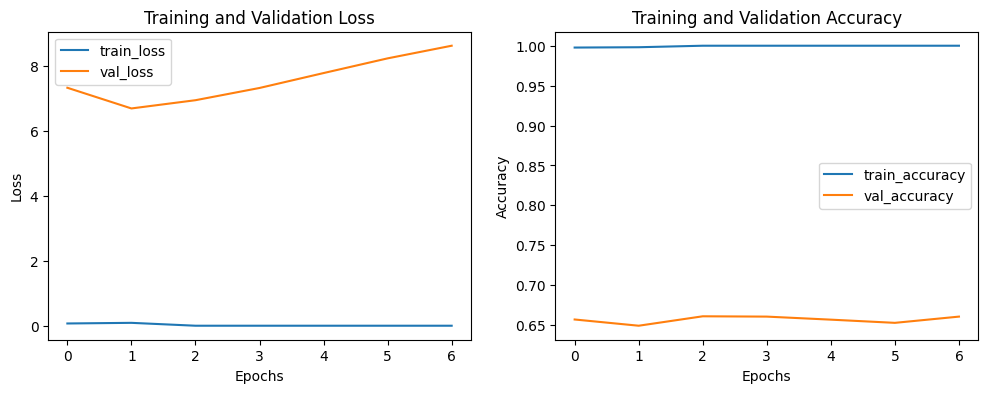

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [38]:
# Ensure the directory for saving model checkpoints exists
checkpoint_dir_mul = 'C:\\Kingsley\\multimodia-hatespeech\\semantic_attention_model'
os.makedirs(checkpoint_dir_mul, exist_ok=True)

In [39]:
semantic_attention_model = semantic_attention_model()

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

ckpt = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_mul, 'best_modelversion22base.h5'),  # Filepath to save the model weights.
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=True,  
    mode='min',  
    verbose=1  
)
semantic_attention_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [177]:
semantic_attention_model.save_weights('semantic_model_weights_v2.h5')

In [40]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

#Training data loader
train_data_loader = load_data(train_ids, mode = 'text')  # Replace with your data loader function

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'text')  # Replace with your validation data loader function

test_data_loader = load_data(test_ids, mode = 'text')

# semantic_attention_model.load_weights('/kaggle/input/lstm-modelh5/best_model.h5')

# Train the model using model.fit
history = semantic_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)


100%|██████████| 134823/134823 [00:00<00:00, 216327.71it/s]


134823
Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8506

100%|██████████| 5000/5000 [00:00<00:00, 213733.39it/s]


5000

Epoch 1: val_loss improved from inf to 0.66987, saving model to C:\Kingsley\multimodia-hatespeech\semantic_attention_model\best_modelversion22.h5
4213/4213 [==============================] - 549s 129ms/step - loss: 0.3357 - accuracy: 0.8506 - val_loss: 0.6699 - val_accuracy: 0.7612
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8526
Epoch 2: val_loss did not improve from 0.66987
4213/4213 [==============================] - 549s 130ms/step - loss: 0.3198 - accuracy: 0.8526 - val_loss: 2.5921 - val_accuracy: 0.3169
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8548
Epoch 3: val_loss did not improve from 0.66987
4213/4213 [==============================] - 550s 131ms/step - loss: 0.3153 - accuracy: 0.8548 - val_loss: 1.5312 - val_accuracy: 0.2927
Epoch 4/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8543
Epoch 4: val_loss did not improve from 0.66987
42

In [41]:
semantic_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)
# print(len(val_ids))

156/156 [==============================] - 17s 107ms/step - loss: 0.6699 - accuracy: 0.7612


[0.6698742508888245, 0.7612179517745972]

In [42]:
semantic_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 200950.73it/s]


10000
312/312 [==============================] - 34s 108ms/step - loss: 0.7857 - accuracy: 0.8008


[0.7857232689857483, 0.80078125]

In [40]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

#Training data loader
train_data_loader = load_data(train_ids, mode = 'text')  # Replace with your data loader function

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'text')  # Replace with your validation data loader function

test_data_loader = load_data(test_ids, mode = 'text')

# semantic_attention_model.load_weights('/kaggle/input/lstm-modelh5/best_model.h5')

# Train the model using model.fit
history = semantic_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)


100%|██████████| 134823/134823 [00:00<00:00, 192609.98it/s]


134823
Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8503

100%|██████████| 5000/5000 [00:00<00:00, 199825.82it/s]


5000

Epoch 1: val_loss improved from inf to 0.59498, saving model to C:\Kingsley\multimodia-hatespeech\semantic_attention_model\best_modelversion22base.h5
4213/4213 [==============================] - 698s 164ms/step - loss: 0.3304 - accuracy: 0.8503 - val_loss: 0.5950 - val_accuracy: 0.7534
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3218 - accuracy: 0.8533
Epoch 2: val_loss did not improve from 0.59498
4213/4213 [==============================] - 598s 142ms/step - loss: 0.3218 - accuracy: 0.8533 - val_loss: 0.8054 - val_accuracy: 0.7536
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8546
Epoch 3: val_loss did not improve from 0.59498
4213/4213 [==============================] - 594s 141ms/step - loss: 0.3151 - accuracy: 0.8546 - val_loss: 0.8099 - val_accuracy: 0.7498
Epoch 4/10
4213/4213 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8546
Epoch 4: val_loss did not improve from 0.5949

In [41]:
semantic_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)

156/156 [==============================] - 30s 190ms/step - loss: 0.5950 - accuracy: 0.7534


[0.5949798822402954, 0.7534054517745972]

In [42]:
semantic_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

100%|██████████| 10000/10000 [00:00<00:00, 178827.26it/s]


10000
312/312 [==============================] - 57s 183ms/step - loss: 0.6243 - accuracy: 0.8086


[0.6243159770965576, 0.80859375]

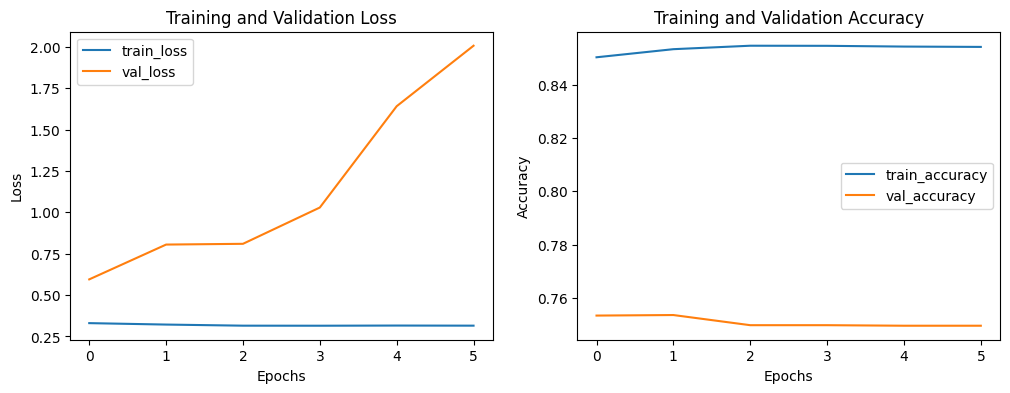

In [47]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [48]:
# save individual models

semantic_attention_model.save('C:\\Kingsley\\multimodia-hatespeech\\semantic_attention_model\\best_modelversion22_v2base.h5')


In [49]:
# Ensure the directory for saving model checkpoints exists
checkpoint_dir_mul = 'C:\\Kingsley\\multimodia-hatespeech\\multimodal_attention_model'
os.makedirs(checkpoint_dir_mul, exist_ok=True)

In [58]:
multimodal_attention_model = multimodal_attention_model()

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

ckpt = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir_mul, 'best_modelversion22base.h5'),  # Filepath to save the model weights.
    monitor='val_loss',  
    save_best_only=True, 
    save_weights_only=True,  
    mode='min',  
    verbose=1  
)
multimodal_attention_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [180]:
multimodal_attention_model.save_weights('multimodal_model_weights_v2.h5')

In [45]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'both')  

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'both') 

test_data_loader = load_data(test_ids, mode = 'both')

# Train the model using model.fit
history = multimodal_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)

# multimodal_attention_model.load_weights('/kaggle/working/multimodal_attn_model_ckpts/best_mm_model.h5')

100%|██████████| 134823/134823 [00:00<00:00, 208846.42it/s]


134823
Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9978

100%|██████████| 5000/5000 [00:00<00:00, 227988.48it/s]


5000

Epoch 1: val_loss improved from inf to 5.48460, saving model to C:\Kingsley\multimodia-hatespeech\multimodal_attention_model\best_modelversion22.h5
4213/4213 [==============================] - 567s 133ms/step - loss: 0.0376 - accuracy: 0.9978 - val_loss: 5.4846 - val_accuracy: 0.6450
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9974
Epoch 2: val_loss improved from 5.48460 to 4.17348, saving model to C:\Kingsley\multimodia-hatespeech\multimodal_attention_model\best_modelversion22.h5
4213/4213 [==============================] - 563s 134ms/step - loss: 0.0539 - accuracy: 0.9974 - val_loss: 4.1735 - val_accuracy: 0.6560
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9988
Epoch 3: val_loss did not improve from 4.17348
4213/4213 [==============================] - 564s 134ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 4.7592 - val_accuracy: 0.6254
Epoch 4/10
4213/4213 [==================

In [ ]:
epochs = 50

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'both')  

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'both') 

test_data_loader = load_data(test_ids, mode = 'both')

# Train the model using model.fit
history = multimodal_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)

# multimodal_attention_model.load_weights('/kaggle/working/multimodal_attn_model_ckpts/best_mm_model.h5')

100%|██████████| 134823/134823 [00:00<00:00, 214169.17it/s]


134823
Epoch 1/50
4213/4213 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9966

100%|██████████| 5000/5000 [00:00<00:00, 95196.14it/s]


5000

Epoch 1: val_loss improved from inf to 3.77449, saving model to /kaggle/working/multimodal_attn_model_ckpts/best_mm_model.h5
4213/4213 [==============================] - 1069s 251ms/step - loss: 0.0507 - accuracy: 0.9966 - val_loss: 3.7745 - val_accuracy: 0.6360
Epoch 2/50
4213/4213 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9973
Epoch 2: val_loss did not improve from 3.77449
4213/4213 [==============================] - 1054s 250ms/step - loss: 0.0468 - accuracy: 0.9973 - val_loss: 4.4889 - val_accuracy: 0.6324
Epoch 3/50
4213/4213 [==============================] - ETA: 0s - loss: 6.3738e-06 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 3.77449
4213/4213 [==============================] - 1049s 249ms/step - loss: 6.3738e-06 - accuracy: 1.0000 - val_loss: 5.2322 - val_accuracy: 0.6244
Epoch 4/50
4213/4213 [==============================] - ETA: 0s - loss: 4.6840e-07 - accuracy: 1.0000
Epoch 4: val_loss did not improve from 3.77449
4213/421

In [130]:
multimodal_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)
# print(len(val_ids))

156/156 [==============================] - 17s 112ms/step - loss: 4.6268 - accuracy: 0.6795


[4.626843452453613, 0.6794871687889099]

In [131]:
multimodal_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

100%|██████████| 10000/10000 [00:00<00:00, 212576.48it/s]


10000
312/312 [==============================] - 37s 117ms/step - loss: 3.7669 - accuracy: 0.7031


[3.766915798187256, 0.703125]

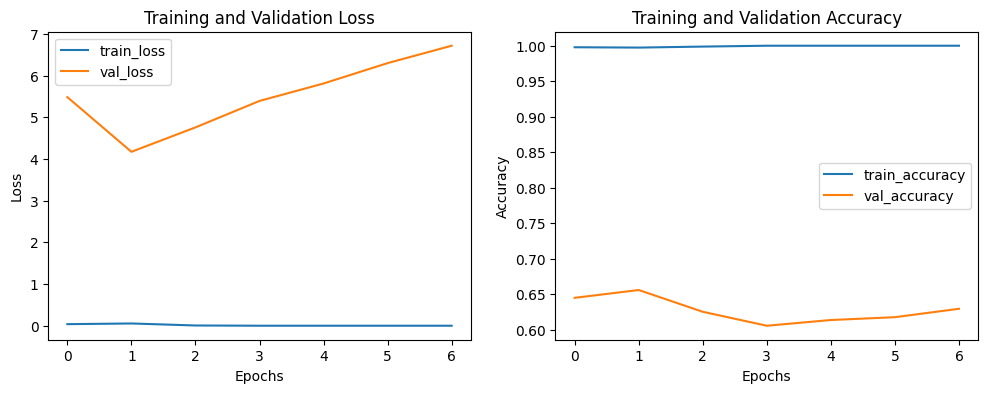

In [50]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [59]:
epochs = 10

steps_per_epoch = len(train_ids)//32
val_steps = len(val_ids)//32

# Training data loader
train_data_loader = load_data(train_ids, mode = 'both')  

# Validation data loader
val_data_loader = load_data(val_ids, mode = 'both') 

test_data_loader = load_data(test_ids, mode = 'both')

# Train the model using model.fit
history = multimodal_attention_model.fit(
    train_data_loader,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data_loader,
    validation_steps=val_steps,
    callbacks=[es, ckpt]
)

# multimodal_attention_model.load_weights('/kaggle/working/multimodal_attn_model_ckpts/best_mm_model.h5')

100%|██████████| 134823/134823 [00:00<00:00, 204031.59it/s]


134823
Epoch 1/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9961

100%|██████████| 5000/5000 [00:00<00:00, 187646.14it/s]


5000

Epoch 1: val_loss improved from inf to 9.76452, saving model to C:\Kingsley\multimodia-hatespeech\multimodal_attention_model\best_modelversion22base.h5
4213/4213 [==============================] - 844s 197ms/step - loss: 0.0718 - accuracy: 0.9961 - val_loss: 9.7645 - val_accuracy: 0.6601
Epoch 2/10
4213/4213 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9976
Epoch 2: val_loss improved from 9.76452 to 4.20155, saving model to C:\Kingsley\multimodia-hatespeech\multimodal_attention_model\best_modelversion22base.h5
4213/4213 [==============================] - 801s 190ms/step - loss: 0.0391 - accuracy: 0.9976 - val_loss: 4.2015 - val_accuracy: 0.6799
Epoch 3/10
4213/4213 [==============================] - ETA: 0s - loss: 2.9610e-06 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 4.20155
4213/4213 [==============================] - 656s 156ms/step - loss: 2.9610e-06 - accuracy: 1.0000 - val_loss: 4.8773 - val_accuracy: 0.6761
Epoch 4/10
4213/4213 [==

In [60]:
multimodal_attention_model.evaluate(val_data_loader, steps = len(val_ids)//32)
# print(len(val_ids))

156/156 [==============================] - 19s 121ms/step - loss: 4.2015 - accuracy: 0.6799


[4.2015485763549805, 0.6798878312110901]

In [61]:
multimodal_attention_model.evaluate(test_data_loader, steps = len(test_ids)//32)

100%|██████████| 10000/10000 [00:00<00:00, 129751.78it/s]


10000
312/312 [==============================] - 40s 130ms/step - loss: 4.2677 - accuracy: 0.6836


[4.267696857452393, 0.68359375]

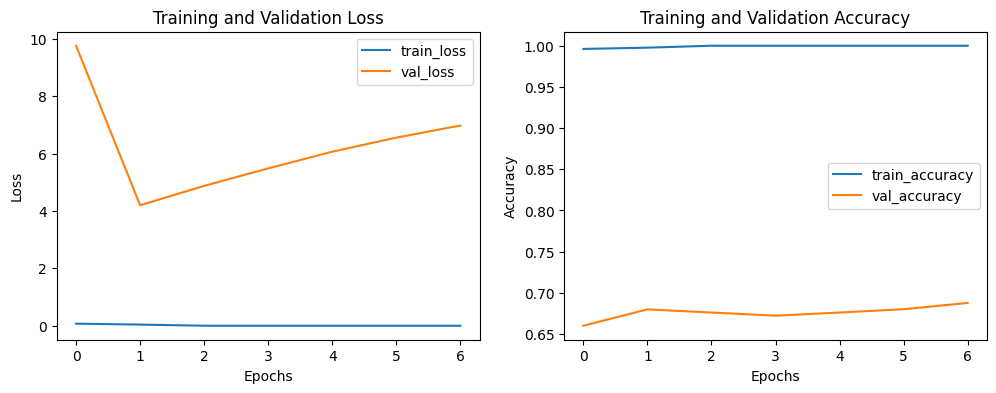

In [64]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [63]:
# save  models
multimodal_attention_model.save('C:\\Kingsley\\multimodia-hatespeech\\multimodal_attention_model\\best_modelversion22base.h5')

In [46]:
def combine_predictions(predictions_list):
    
    num_samples = len(predictions_list[0])  # Assuming all models have the same number of samples
    combined_predictions = []

    for i in range(num_samples):
        # Extract predictions for the i-th sample from all models
        sample_predictions = [model_predictions[i] for model_predictions in predictions_list]

        # Count the number of 1s and 0s
        num_ones = np.sum(sample_predictions)
        num_zeros = len(sample_predictions) - num_ones

        # Determine the majority vote
        if num_ones > num_zeros:
            combined_predictions.append(1)
        else:
            combined_predictions.append(0)

    return combined_predictions


In [47]:
comb_preds = []
true_preds = []

for num_steps in range(len(test_ids)//32):
    
    ##Dataloader being used here must have been instantiated with the 'both' argument
    
    x_batch, y_batch = next(test_data_loader)
    
    vis_preds = visual_attention_model.predict(x_batch[0])
    sem_preds = semantic_attention_model.predict(x_batch[1])
    mm_preds = multimodal_attention_model.predict(x_batch)
    
    final_preds = combine_predictions([vis_preds, sem_preds, mm_preds])
    
    comb_preds.extend(final_preds)
    true_preds.extend(list(y_batch))


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 212574.32it/s]


10000
1/1 [==============================] - 0s 27ms/step


In [48]:
print(classification_report(true_preds, comb_preds))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      8073
           1       0.16      0.10      0.12      1911

    accuracy                           0.73      9984
   macro avg       0.48      0.49      0.48      9984
weighted avg       0.68      0.73      0.70      9984



Model Deployment

In [ ]:
# Load your individual models
visual_attention_model = load_model('C:\\Kingsley\\multimodia-hatespeech\\visual_attn_model\\best_modelversion22.h5')
semantic_attention_model = load_model('C:\\Kingsley\\multimodia-hatespeech\\semantic_attention_model\\best_modelversion22.h5')
multimodal_attention_model = load_model('C:\\Kingsley\\multimodia-hatespeech\\multimodal_attention_model\\best_modelversion22.h5')

In [148]:
a = visual_attention_model.load_weights('visual_model_weights.h5')
b = semantic_attention_model.load_weights('semantic_model_weights.h5')
c = multimodal_attention_model.load_weights('multimodal_model_weights.h5')

In [ ]:
a.summary()

In [153]:
visual_attention_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_feature_extractor (Fu  (None, 64)               1189633   
 nctional)                                                       
                                                                 
 dense_48 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,189,698
Trainable params: 1,189,570
Non-trainable params: 128
_________________________________________________________________


In [151]:
semantic_attention_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_12 (Functional)       (None, 64)                8149185   
                                                                 
 dense_52 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,149,250
Trainable params: 8,149,250
Non-trainable params: 0
_________________________________________________________________


In [152]:
multimodal_attention_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_28 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 image_feature_extractor (Funct  (None, 64)          1189633     ['input_27[0][0]']               
 ional)                                                                                           
                                                                                           

In [54]:
# Define the majority voting function
def combine_predictions(predictions_list):
    num_samples = len(predictions_list[0])
    combined_predictions = []

    for i in range(num_samples):
        sample_predictions = [model_predictions[i] for model_predictions in predictions_list]
        num_ones = np.sum(sample_predictions)
        num_zeros = len(sample_predictions) - num_ones

        if num_ones > num_zeros:
            combined_predictions.append(1)
        else:
            combined_predictions.append(0)

    return combined_predictions

In [155]:
# Define the combined model class
class CombinedModel(tf.keras.Model):
    def __init__(self, visual_model, semantic_model, multimodal_model):
        super(CombinedModel, self).__init__()
        self.visual_model = visual_model
        self.semantic_model = semantic_model
        self.multimodal_model = multimodal_model

    def call(self, inputs):
        image_input, text_input = inputs
        
        vis_preds = self.visual_model.predict(image_input)
        sem_preds = self.semantic_model.predict(text_input)
        mm_preds = self.multimodal_model.predict([image_input, text_input])
        
        final_preds = combine_predictions([vis_preds, sem_preds, mm_preds])
        return final_preds

In [156]:
combined_model = CombinedModel(visual_attention_model, semantic_attention_model, multimodal_attention_model)

Streamlit


In [16]:
# Load models
visual_attention_model = load_model('C:\\Kingsley\\multimodia-hatespeech\\visual_attn_model\\best_modelversion22v2.h5')
semantic_attention_model = load_model('C:\\Kingsley\\multimodia-hatespeech\\semantic_attention_model\\best_modelversion22_v2.h5')
multimodal_attention_model = load_model('C:\\Kingsley\multimodia-hatespeech\multimodal_attention_model\\best_modelversion22_v2.h5')